
# **TABLE TRANSFORMER - DETR**
Two functionalities implemented: Table Detection (TD) and Table Structure Recognition (TSR)

## **1.- Install dependencies and download repository**

In [1]:
!rm -r transformers
!git clone -b add_table_transformer https://github.com/nielsrogge/transformers.git
!cd transformers
!pip install -q ./transformers
!pip install -q timm

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 144547, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 144547 (delta 287), reused 345 (delta 204), pack-reused 144089
Receiving objects: 100% (144547/144547), 120.54 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (106773/106773), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 7.

## **2.- Download dataset or input images**


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/MyDrive/Colab Notebooks/oculist-sparkocr/dataset/test.zip" "/content/test.zip"
!unzip "/content/test.zip"


Mounted at /content/drive/
Archive:  /content/test.zip
   creating: test/
  inflating: test/1.PNG              
  inflating: test/2.PNG              


## **3.- Imports**

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
from datetime import datetime

from transformers import DetrFeatureExtractor
from transformers import DetrForObjectDetection

## **4.- Define auxiliar functions**

In [9]:
# colors for visualization
colors = ["red", "blue", "green", "yellow", "orange", "violet"]

# class_to_show:: define results classes that are going to be show:
#   [column, row, column header, row header...]
#   by defaoult 0 = columns
#   use 999 to show all the different objects obtained

def plot_results(pil_img, prob, boxes, model, class_to_show=0):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show or class_to_show == 999:
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=colors[cl.item()], linewidth=3))
          text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
        else:
          continue
    plt.axis('off')
    plt.show()

In [10]:
def crop_tables(pil_img, prob, boxes, margin=0, class_to_show=0): # class zero is the detected table
    result_images = []
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
          width, height = pil_img.size
          crop_xmin = max(0, xmin - margin)
          crop_ymin = max(0, ymin - margin)
          crop_xmax = min(width, xmax + margin)
          crop_ymax = min(height, ymax + margin)
          pil_img_crop = pil_img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))
          result_images.append(pil_img_crop)
        else:
          continue
    return result_images


In [11]:
# def adapt_results(prob, boxes, ima_w, ima_h, padding):
#     '''{0: 'table',
#     1: 'table column',
#     2: 'table row',
#     3: 'table column header',
#     4: 'table projected row header',
#     5: 'table spanning cell'}'''
#     result_images = []
#     for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
#         cl = p.argmax()
#         # column
#         if cl.item() == '1' or cl.item() == '3':
#           width, height = pil_img.size
#           crop_xmin = max(0, xmin - margin)
#           crop_ymin = max(0, ymin - margin)
#           crop_xmax = min(width, xmax + margin)
#           crop_ymax = min(height, ymax + margin)
#           pil_img_crop = pil_img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))
#           result_images.append(pil_img_crop)
#         # rows
#         if cl.item() == '2' or cl.item() == '4':

#         else:
#           continue
#     return result_images

In [12]:
def add_padding(pil_img, padding, color):
    width, height = pil_img.size
    new_width = width + padding*2
    new_height = height + padding*2
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (padding, padding))
    return result

## **5.- Inference**

#### Single inference
Execution of a single inference of an input document image (TD + TSR)

**TABLE DETECTION RESULT**


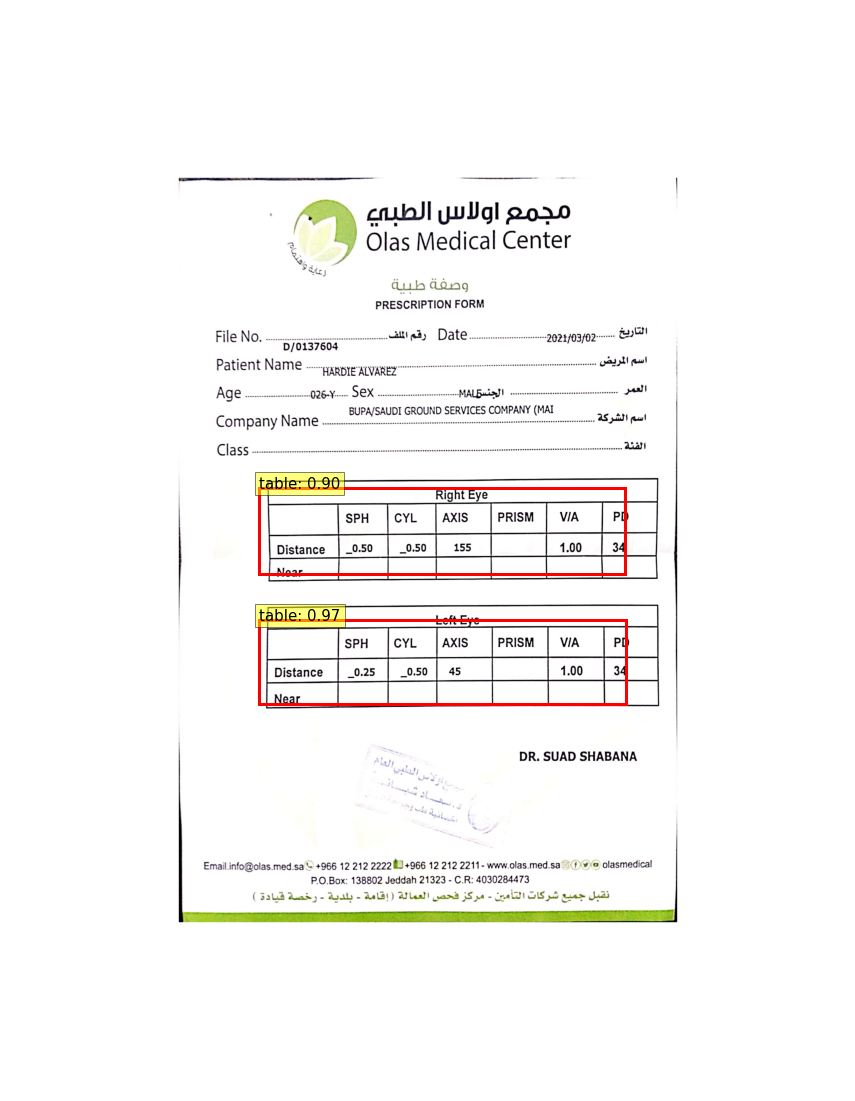


**TABLE STRUCTURE RECOGNITON RESULT**


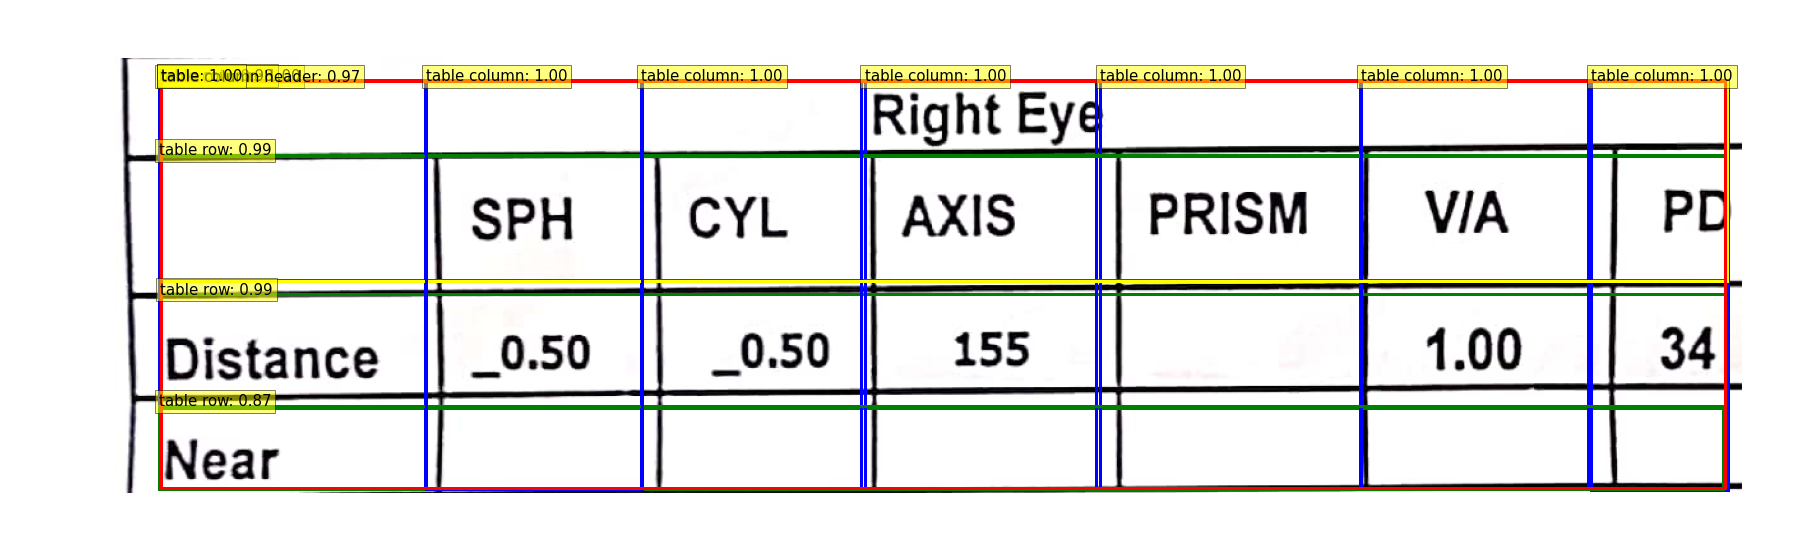


**TABLE STRUCTURE RECOGNITON RESULT**


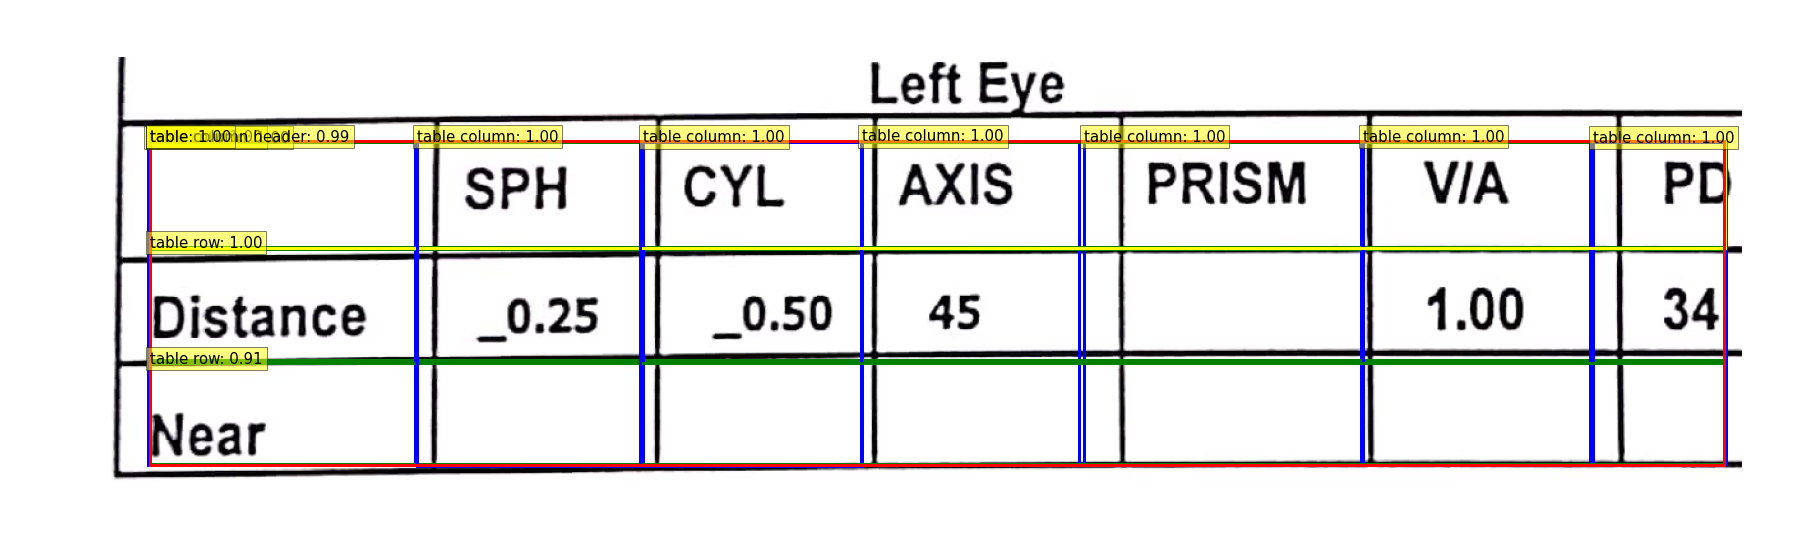

In [ ]:
## Input variables
IMG_PATH = r"/content/images/3.jpg" # path to the input image
PLOT_RES = 1 # (0:not plot images, 1:plot table detection and table structure results)

# Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

# Input image
image = Image.open(IMG_PATH).convert("RGB")
image = add_padding(pil_img = image, padding = 600, color = (255, 255, 255))

# width, height = image.size
# image.resize((int(width*0.5), int(height*0.5)))

### TABLE DETECTION
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()
with torch.no_grad():
  outputs = model_td(**encoding)
# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas_td = outputs.logits.softmax(-1)[0, :, :-1]
keep_td = probas_td.max(-1).values > 0.9
# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
    
image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 20)

if image_cropped != []:
  ### Show original image with tables detected
  if PLOT_RES == 1:
    print("**TABLE DETECTION RESULT**")
    plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)

  for ima_crop in image_cropped:
    # Padding
    ima_crop = add_padding(pil_img = ima_crop, padding = 40, color = (255, 255, 255))

    ### TABLE STRUCTURE RECOGNITION
    start_time_val = datetime.now()
    encoding = feature_extractor(ima_crop, return_tensors="pt")
    encoding.keys()
    # print(encoding['pixel_values'].shape)
    with torch.no_grad():
      outputs = model_tsr(**encoding)
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
    probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
    keep_tsr = probas_tsr.max(-1).values > 0.6
    # rescale bounding boxes
    target_sizes = torch.tensor(ima_crop.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]
    time_tsr = ((datetime.now() - start_time_val).total_seconds())

    ### Show struture of each table
    if PLOT_RES == 1:
      print("\n**TABLE STRUCTURE RECOGNITON RESULT**")
      plot_results(ima_crop, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)

else:
    print("No table detected")

Execution of a single inference of an input document image (TSR)

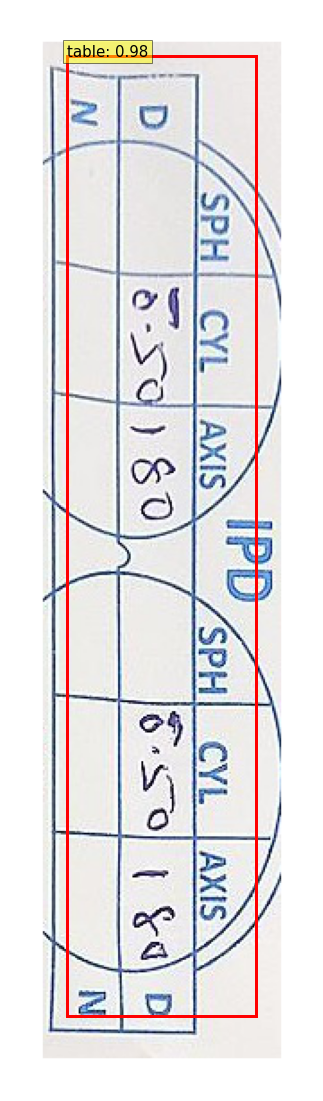


**TSR -> TABLE COLUMN**


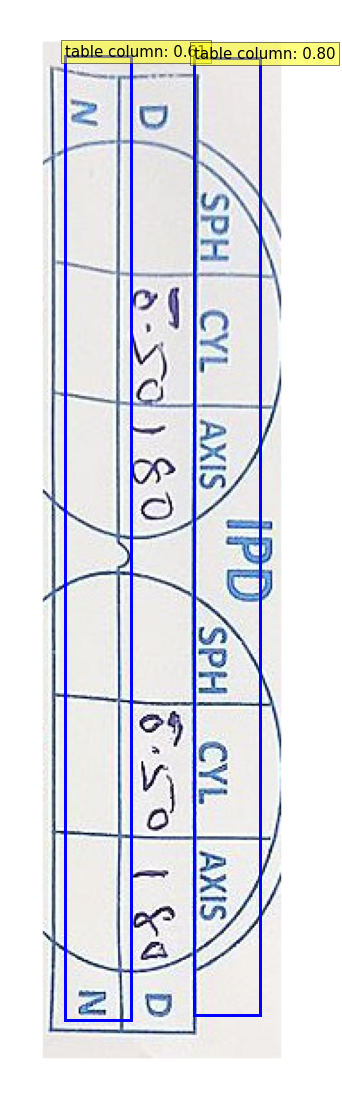


**TSR -> TABLE ROW**


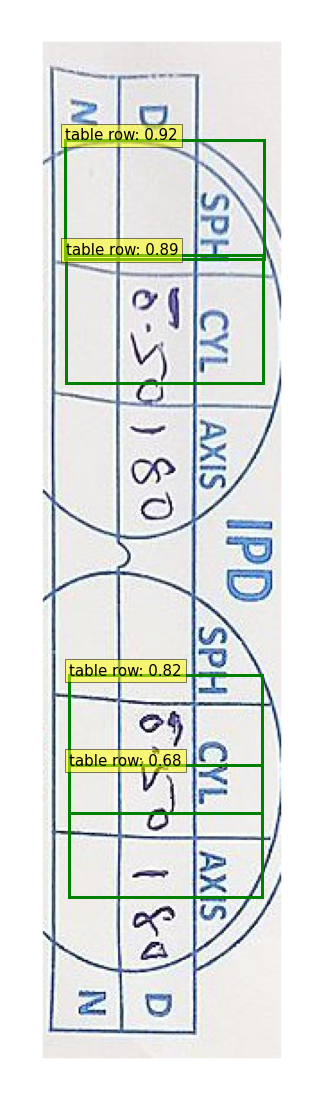

In [ ]:
## Input variables
IMG_PATH = r"/content/img_tables/24.jpg" # path to the input image
PLOT_RES = 1 # (0:not plot images, 1:plot table detection and table structure results)
padding = 20

# Load models
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

# Input image
image = Image.open(IMG_PATH).convert("RGB")
ima_w, ima_h = image.size


# Padding
ima_padd = add_padding(pil_img = image, padding = padding, color = (255, 255, 255))
# ima_w, ima_h = ima_padd.size
# ima_padd.resize((int(ima_w*0.5), int(ima_h*0.5)))

### TABLE STRUCTURE RECOGNITION
start_time_val = datetime.now()
encoding = feature_extractor(ima_padd, return_tensors="pt")
encoding.keys()
# print(encoding['pixel_values'].shape)
with torch.no_grad():
  outputs = model_tsr(**encoding)
# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
keep_tsr = probas_tsr.max(-1).values > 0.6
# rescale bounding boxes
target_sizes = torch.tensor(ima_padd.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]
time_tsr = ((datetime.now() - start_time_val).total_seconds())

# # Modify fils and cols to fill the complete table image
# bboxes_scaled_tsr = adapt_results(probas_tsr[keep_tsr], bboxes_scaled_tsr, ima_w, ima_h, padding)

'''{0: 'table',
1: 'table column',
2: 'table row',
3: 'table column header',
4: 'table projected row header',
5: 'table spanning cell'}'''

plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr)

### Show struture of each table
if PLOT_RES == 1:
  print("\n**TSR -> TABLE COLUMN**")
  plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=1)
### Show struture of each table
if PLOT_RES == 1:
  print("\n**TSR -> TABLE ROW**")
  plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=2)
### Show struture of each table
# if PLOT_RES == 1:
#   print("\n**TSR -> TABLE COLUMN HEADER**")
#   plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=3)
# ### Show struture of each table
# if PLOT_RES == 1:
#   print("\n**TSR -> TABLE ROW HEADER**")
#   plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=4)
# ### Show struture of each table
# if PLOT_RES == 1:
#   print("\n**TSR -> TABLE CELL**")
#   plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=5)
# ### Show struture of each table
# if PLOT_RES == 1:
#   print("\n**TSR**")
#   plot_results(ima_padd, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)


#### Dataset inference
Execution of the pipeline inference on a dataset of document images

In [16]:
## Input variables
IMG_PATH = r"/content/test/" # path to the tables dataset
PLOT_RES = 1 # (0:not plot images, 1:plot table detection and table structure results)

## Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

CONT_IMAS = 0
CONT_TABLES = 0
time_total = 0

files = os.listdir(IMG_PATH)
for file in sorted(files):
  if file.endswith(".jpg") or file.endswith(".PNG") or file.endswith(".tif"):
    # Input
    file_path = IMG_PATH + file
    image = Image.open(file_path).convert("RGB")
    print("\n\n\n*********************************************************************************************************************")
    print(f"Processing {file_path} ...........")
    CONT_IMAS += 1
    ## Resize
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))

    ### TABLE DETECTION
    start_time_val = datetime.now()
    encoding = feature_extractor(image, return_tensors="pt")
    encoding.keys()
    with torch.no_grad():
      outputs = model_td(**encoding)
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
    probas_td = outputs.logits.softmax(-1)[0, :, :-1]
    keep_td = probas_td.max(-1).values > 0.9
    # rescale bounding boxes
    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
    time_td = ((datetime.now() - start_time_val).total_seconds())
    
    image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 40)

    # Table detected
    if image_cropped != []:
      print("... Number of tables detected: ",len(image_cropped))
      ### Show original image with tables detected
      if PLOT_RES == 1:
        plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)

      for ima_crop in image_cropped:
        CONT_TABLES += 1
        # Padding
        print("... Table structure recognized:")
        ima_crop = add_padding(pil_img = ima_crop, padding = 40, color = (255, 255, 255))

        ### TABLE STRUCTURE RECOGNITION
        start_time_val = datetime.now()
        encoding = feature_extractor(ima_crop, return_tensors="pt")
        encoding.keys()
        # print(encoding['pixel_values'].shape)
        with torch.no_grad():
          outputs = model_tsr(**encoding)
        # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
        probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
        keep_tsr = probas_tsr.max(-1).values > 0.6
        # rescale bounding boxes
        target_sizes = torch.tensor(ima_crop.size[::-1]).unsqueeze(0)
        postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
        bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]
        time_tsr = ((datetime.now() - start_time_val).total_seconds())

        ### Show struture of each table
        if PLOT_RES == 1:
          plot_results(ima_crop, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)

        time_total = time_total + time_td + time_tsr

    else:
      print("... Not table detected in ", file_path)
      time_tsr=0

    print(f" TOTAL TIME: {str(time_td + time_tsr)}")

print("\n\n***********************************************************")
print(f"**** Total number of images processed: {CONT_IMAS} ")
print(f"**** Total number of tables detected: {CONT_TABLES} ")
print(f"**** SCORE: {CONT_TABLES/CONT_IMAS}  (supossing one table per image)")
print(f"**** MEAN TIME: {time_total/CONT_TABLES} (with td and tsr)")
print("***********************************************************")

Output hidden; open in https://colab.research.google.com to view.

# TD Evaluation in ICDAR19 TRACKA

Download dataset with GT

In [ ]:
!wget -O TRACKA_test.zip https://zenodo.org/record/3239032/files/TRACKA_test.zip?download=1
!unzip -d TRACKA_test TRACKA_test.zip
!wget -O TrackA_test_GT.zip https://zenodo.org/record/3239032/files/TrackA_test_GT.zip?download=1
#!unzip -d TrackA_test_GT TrackA_test_GT.zip
!wget https://pypi.johnsnowlabs.com/3.5.0-567fa636bc707feffe12e85e49117f02b5897da2/jars/spark-ocr-assembly-3.5.0-spark30.jar
!git clone https://github.com/cndplab-founder/ctdar_measurement_tool.git
!unzip -d /content/ctdar_measurement_tool/annotations/ TrackA_test_GT.zip


!gdown --id 1Qm3sxeKBXYOXUwSVV3Fztf9M4BG6nJZY -O reg.tar.gz
!tar -xvf reg.tar.gz
#!mkdir result
#!rm /content/result/*

import glob

def get_fname(path):
    res = path.split("/")[-1].split(".")[0]
    return res

processed = [get_fname(x) for x in glob.glob("/content/result/*")]
len(processed)

--2022-10-07 07:25:16--  https://zenodo.org/record/3239032/files/TRACKA_test.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791479577 (755M) [application/octet-stream]
Saving to: ‘TRACKA_test.zip’

TRACKA_test.zip     100%[===================>] 754.81M  8.99MB/s    in 94s     

2022-10-07 07:26:51 (8.05 MB/s) - ‘TRACKA_test.zip’ saved [791479577/791479577]

Archive:  TRACKA_test.zip
  inflating: TRACKA_test/cTDaR_t00011.jpg  
  inflating: TRACKA_test/cTDaR_t00012.jpg  
  inflating: TRACKA_test/cTDaR_t00013.jpg  
  inflating: TRACKA_test/cTDaR_t00070.jpg  
  inflating: TRACKA_test/cTDaR_t00071.jpg  
  inflating: TRACKA_test/cTDaR_t00072.jpg  
  inflating: TRACKA_test/cTDaR_t00073.jpg  
  inflating: TRACKA_test/cTDaR_t00074.jpg  
  inflating: TRACKA_test/cTDaR_t00075.jpg  
  inflating: TRACKA_test/cTDaR_t00076.jpg  
  inflating: TRACKA_test/

210

Run inference saving reuslts for evaluation

In [ ]:
!gdown --id 1Qm3sxeKBXYOXUwSVV3Fztf9M4BG6nJZY -O reg.tar.gz
!tar -xvf reg.tar.gz
#!mkdir result
#!rm /content/result/*

import glob

def get_fname(path):
    res = path.split("/")[-1].split(".")[0]
    return res


processed = [get_fname(x) for x in glob.glob("/content/result/*")]
len(processed)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qm3sxeKBXYOXUwSVV3Fztf9M4BG6nJZY
To: /content/reg.tar.gz
100% 11.0k/11.0k [00:00<00:00, 15.8MB/s]
result/
result/cTDaR_t10109.xml
result/cTDaR_t10108.xml
result/cTDaR_t10043.xml
result/cTDaR_t10140.xml
result/cTDaR_t10195.xml
result/cTDaR_t10091.xml
result/cTDaR_t10185.xml
result/cTDaR_t10196.xml
result/cTDaR_t10089.xml
result/cTDaR_t10221.xml
result/cTDaR_t10166.xml
result/cTDaR_t10231.xml
result/cTDaR_t10209.xml
result/cTDaR_t10070.xml
result/cTDaR_t10031.xml
result/cTDaR_t10097.xml
result/cTDaR_t10019.xml
result/cTDaR_t10051.xml
result/cTDaR_t10078.xml
result/cTDaR_t10175.xml
result/cTDaR_t10146.xml
result/cTDaR_t10104.xml
result/cTDaR_t10106.xml
result/cTDaR_t10236.xml
result/cTDaR_t10129.xml
result/cTDaR_t101

210

In [ ]:
def crop_tables(pil_img, prob, boxes, margin=0, class_to_show=0): # class zero is the detected table
    result_images = []
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
          width, height = pil_img.size
          crop_xmin = max(0, xmin - margin)
          crop_ymin = max(0, ymin - margin)
          crop_xmax = min(width, xmax + margin)
          crop_ymax = min(height, ymax + margin)
          pil_img_crop = pil_img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))
          result_images.append(pil_img_crop)
        else:
          continue
    return result_images

def save_tables_validation(root, prob, boxes, class_to_show=0): # class zero is the detected table
    i = 1
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
          x1 = str(int(xmin))
          y1 = str(int(ymin))
          x2 = str(int(xmax))
          y2 = str(int(ymax))
          k = x1 + "," + y1 + " " + x1 + "," + y2 + " " + x2 + "," + y2 + " " + x2 + "," + y1
          #tbls[k] = tbl.score
          tble = etree.Element('table')
          tble.attrib['id'] = str(i)
          i = i + 1
          coords = etree.Element('Coords')
          coords.attrib['points'] = k
          tble.append(coords)
          root.append(tble)
        else:
          continue
    return root

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
from datetime import datetime

from transformers import DetrFeatureExtractor
from transformers import DetrForObjectDetection

from lxml import etree
from xml.etree.ElementTree import ElementTree, Element
import os

## Input variables
IMG_PATH = r"/content/TRACKA_test/" # path to the tables dataset

## Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

files = os.listdir(IMG_PATH)
for file in sorted(files):
  if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".tif"):
  # if file == "cTDaR_t10023.jpg":
    try:
      # Input
      file_path = IMG_PATH + file
      image = Image.open(file_path).convert("RGB")
      print(f"Processing {file_path} ...........")
      ## Resize
      width, height = image.size
      image.resize((int(width*0.5), int(height*0.5)))

      ### TABLE DETECTION
      start_time_val = datetime.now()
      encoding = feature_extractor(image, return_tensors="pt")
      encoding.keys()
      with torch.no_grad():
        outputs = model_td(**encoding)
      # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
      ################ THRESHOLD = 0.5 AS IN THE OTHER ALGORITHMS
      probas_td = outputs.logits.softmax(-1)[0, :, :-1]
      keep_td = probas_td.max(-1).values > 0.5
      # rescale bounding boxes
      target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
      postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
      bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
      time_td = ((datetime.now() - start_time_val).total_seconds())
      
      image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 20)

      fname = file_path.split("/")[-1]
      fname = fname.split(".")[0]
      root = etree.Element('document')
      root.attrib['filename'] = fname

      # Table detected
      if image_cropped != []:
        print("... Number of tables detected: ",len(image_cropped))
        # plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)
        root = save_tables_validation(root, probas_td[keep_td], bboxes_scaled_td, class_to_show=0)
      else:
        print("... Not table detected")
        # image.resize((int(width*0.5), int(height*0.5)))
        # display(image)

      tree = ElementTree(root)
      tree.write("result/" + fname + ".xml")

    except:
      print("ERROR")

!tar -cvzf reg.tar.gz result/
!tar -cvzf res_img.tar.gz result_img/

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Processing /content/TRACKA_test/cTDaR_t00011.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00012.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00013.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00070.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00071.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00072.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00073.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00074.jpg ...........
... Number of tables detected:  1
Processing /content/TRACKA_test/cTDaR_t00075.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00076.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00077.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00078.jpg ...........
... 

Remove not processed GT examples

In [ ]:
!wget -O TrackA_test_GT.zip https://zenodo.org/record/3239032/files/TrackA_test_GT.zip?download=1
!unzip -d /content/ctdar_measurement_tool/annotations/ TrackA_test_GT.zip

--2022-10-07 07:47:50--  https://zenodo.org/record/3239032/files/TrackA_test_GT.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137634 (134K) [application/octet-stream]
Saving to: ‘TrackA_test_GT.zip’

TrackA_test_GT.zip  100%[===================>] 134.41K   421KB/s    in 0.3s    

2022-10-07 07:47:52 (421 KB/s) - ‘TrackA_test_GT.zip’ saved [137634/137634]

Archive:  TrackA_test_GT.zip
replace /content/ctdar_measurement_tool/annotations/trackA/cTDaR_t00011.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
processed = [get_fname(x) for x in glob.glob("/content/result/*")]
len(processed)
for f in glob.glob("/content/ctdar_measurement_tool/annotations/trackA/*"):
    if get_fname(f) not in processed:
        os.remove(f)

Run evaluation

In [ ]:
%cd "/content/ctdar_measurement_tool"
!python evaluate.py -trackA "/content/reg.tar.gz"
%cd "/content"

/content/ctdar_measurement_tool
unzipped!
cTDaR_t10115
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10115.xml

Processing... cTDaR_t10115.xml
cTDaR_t10168
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
true: 1, gt: 1, res: 1
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10168.xml

Processing... cTDaR_t10168.xml
cTDaR_t10232
true: 2, gt: 2, res: 2
true: 2, gt: 2, res: 2
true: 1, gt: 2, res: 2
true: 1, gt: 2, res: 2
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10232.xml

Processing... cTDaR_t10232.xml
cTDaR_t10046
true: 1, gt: 2, res: 1
true: 1, gt: 2, res: 1
true: 1, gt: 2, res: 1
true: 1, gt: 2, res: 1
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10046.xml

Processing... cTDaR_t10046.xml
cTDaR_t00783
true: 0, gt: 1, res: 0
true: 0, gt: 1, res: 0
true: 0, gt: 1, res

# TSR Evaluation in ICDAR19 TRACKB

Download dataset with GT

In [ ]:
!gdown 1QgDArwFFqSp_gedCg82iSbtxgcn9BUWA
!unzip TRACKB2_test_modern.zip

!git clone https://github.com/cndplab-founder/ctdar_measurement_tool.git
!git clone https://github.com/cndplab-founder/ICDAR2019_cTDaR.git

!mkdir /content/ctdar_measurement_tool/annotations/trackB2/
!cp /content/ICDAR2019_cTDaR/test_ground_truth/TRACKB2/cTDaR_t1* /content/ctdar_measurement_tool/annotations/trackB2/

!mkdir result

Downloading...
From: https://drive.google.com/uc?id=1QgDArwFFqSp_gedCg82iSbtxgcn9BUWA
To: /content/TRACKB2_test_modern.zip
100% 31.7M/31.7M [00:00<00:00, 156MB/s]
Archive:  TRACKB2_test_modern.zip
   creating: TRACKB2_test_modern/
  inflating: TRACKB2_test_modern/cTDaR_t10000.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10001.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10002.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10003.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10004.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10005.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10006.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10007.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10008.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10009.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10010.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10011.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10012.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t10013.jpg  
  inflating: TRACKB2_test_modern/cTDaR_t1

There are two different evaluation of TSR, with the dataset TrackB1 or with the TrackB2, as explained in:  https://github.com/cndplab-founder/ctdar_measurement_tool 

First step, save TSR results

In [ ]:
from lxml import etree
from xml.etree.ElementTree import ElementTree, Element
from os.path import exists

#score_thr = 0.

def get_Coords_t(tbl):
  x1 = str(int(tbl.x))
  y1 = str(int(tbl.y))
  x2 = str(int(tbl.x + tbl.width))
  y2 = str(int(tbl.y + tbl.height))
  k = x1 + "," + y1 + " " + x1 + "," + y2 + " " + x2 + "," + y2 + " " + x2 + "," + y1
  coords = etree.Element('Coords')
  coords.attrib['points'] = k
  return coords

def get_Coords_c(tbl, region):
  x1 = str(int(tbl[0] + region.x))
  y1 = str(int(tbl[1] + region.y))
  x2 = str(int(tbl[0] + tbl[2] + region.x))
  y2 = str(int(tbl[1] + tbl[3] + region.y))
  k = x1 + "," + y1 + " " + x1 + "," + y2 + " " + x2 + "," + y2 + " " + x2 + "," + y1
  coords = etree.Element('Coords')
  coords.attrib['points'] = k
  return coords

for row in tables_results.select('path', 'region', 'txtRegions').rdd.toLocalIterator():
  fname = row.path.split("/")[-1]
  fname = fname.split(".")[0]
  print(fname)
  out_file = "result/" + fname + ".xml"
  file_exists = exists(out_file)
  if file_exists:
    root = etree.parse(out_file).getroot()
  else:
    root = etree.Element('document')
    root.attrib['filename'] = fname
  result_ = row.txtRegions
  if (len(result_) > 0):
    region = row.region
    tble = etree.Element('table')
    tble.append(get_Coords_t(region))
    clls = {}
    row = -1
    for cll in result_:
      row = row + 1
      column = -1
      for cll_ in cll:
        column =  column + 1
        for cll__ in cll_:
          if cll__ is not None:
            clle = etree.Element('cell')
            clle.set("start-row", str(row))
            clle.set("end-row", str(row))
            clle.set("start-col", str(column))
            clle.set("end-col", str(column))
            clle.append(get_Coords_c(cll__, region))
            tble.append(clle)
    root.append(tble)

  #print(etree.tostring(root, xml_declaration = True, pretty_print = True).decode('UTF-8'))
  tree = ElementTree(root)
  tree.write(out_file)

!tar -cvzf reg.tar.gz result/
!tar -cvzf res_img.tar.gz result_img/

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
from datetime import datetime

from transformers import DetrFeatureExtractor
from transformers import DetrForObjectDetection

from lxml import etree
from xml.etree.ElementTree import ElementTree, Element
import os

## Input variables
IMG_PATH = r"/content/TRACKA_test/" # path to the tables dataset

## Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

files = os.listdir(IMG_PATH)
for file in sorted(files):
  if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".tif"):
  # if file == "cTDaR_t10023.jpg":
    try:
      # Input
      file_path = IMG_PATH + file
      image = Image.open(file_path).convert("RGB")
      print(f"Processing {file_path} ...........")
      ## Resize
      width, height = image.size
      image.resize((int(width*0.5), int(height*0.5)))

      ### TABLE DETECTION
      start_time_val = datetime.now()
      encoding = feature_extractor(image, return_tensors="pt")
      encoding.keys()
      with torch.no_grad():
        outputs = model_td(**encoding)
      # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
      ################ THRESHOLD = 0.5 AS IN THE OTHER ALGORITHMS
      probas_td = outputs.logits.softmax(-1)[0, :, :-1]
      keep_td = probas_td.max(-1).values > 0.5
      # rescale bounding boxes
      target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
      postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
      bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
      time_td = ((datetime.now() - start_time_val).total_seconds())
      
      image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 20)

      fname = file_path.split("/")[-1]
      fname = fname.split(".")[0]
      root = etree.Element('document')
      root.attrib['filename'] = fname

      # Table detected
      if image_cropped != []:
        print("... Number of tables detected: ",len(image_cropped))
        plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)

        for ima_crop in image_cropped:
          ### TABLE STRUCTURE RECOGNITION
          ima_crop = add_padding(pil_img = ima_crop, padding = 40, color = (255, 255, 255))
          encoding = feature_extractor(ima_crop, return_tensors="pt")
          encoding.keys()
          # print(encoding['pixel_values'].shape)
          with torch.no_grad():
            outputs = model_tsr(**encoding)
          # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
          probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
          keep_tsr = probas_tsr.max(-1).values > 0.6
          # rescale bounding boxes
          target_sizes = torch.tensor(ima_crop.size[::-1]).unsqueeze(0)
          postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
          bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]

          plot_results(ima_crop, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)

          # Save results!!!!
          # root = save_cells_validation(root, probas_td[keep_td], bboxes_scaled_td, class_to_show=0)

        # Just save results when a table is detected...
        tree = ElementTree(root)
        tree.write("result/" + fname + ".xml")

      else:
        print("... Not table detected")
        # image.resize((int(width*0.5), int(height*0.5)))
        # display(image)

    except:
      print("ERROR")

!tar -cvzf reg.tar.gz result/
!tar -cvzf res_img.tar.gz result_img/

Processing /content/TRACKA_test/cTDaR_t00011.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00012.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00013.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00070.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00071.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00072.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00073.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00074.jpg ...........
... Number of tables detected:  1
Processing /content/TRACKA_test/cTDaR_t00075.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00076.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00077.jpg ...........
... Not table detected
Processing /content/TRACKA_test/cTDaR_t00078.jpg ...........
... 

*   TRACK B1


In [ ]:
# Download dataset
!wget -O TrackB1_test_GT.zip https://zenodo.org/record/3239032/files/TrackB1_test_GT.zip?download=1
!unzip -d /content/ctdar_measurement_tool/annotations/ TrackB1_test_GT.zip

In [ ]:
# Remove images of dataset that are not in result, and remove result that there are not in dataset
processed = [get_fname(x) for x in glob.glob("/content/result/*")]
len(processed)
for f in glob.glob("/content/ctdar_measurement_tool/annotations/trackB1/*"):
    if get_fname(f) not in processed:
        os.remove(f)
dataset = [get_fname(x) for x in glob.glob("/content/ctdar_measurement_tool/annotations/trackB1/*")]
len(dataset)
for f in glob.glob("/content/result/*"):
    if get_fname(f) not in dataset:
        os.remove(f)

!tar -cvzf reg.tar.gz result/
!tar -cvzf res_img.tar.gz result_img/

In [ ]:
# Run evaluation
%cd "/content/ctdar_measurement_tool"
!python evaluate.py -trackB1 "/content/reg.tar.gz"
%cd "/content"

*   TRACK B2

In [ ]:
# Download dataset
!wget -O TrackB2_test_GT.zip https://zenodo.org/record/3239032/files/TrackB2_test_GT.zip?download=1
!unzip -d /content/ctdar_measurement_tool/annotations/ TrackB2_test_GT.zip

In [ ]:
# Remove images of dataset that are not in result, and remove result that there are not in dataset
processed = [get_fname(x) for x in glob.glob("/content/result/*")]
len(processed)
for f in glob.glob("/content/ctdar_measurement_tool/annotations/trackB2/*"):
    if get_fname(f) not in processed:
        os.remove(f)
dataset = [get_fname(x) for x in glob.glob("/content/ctdar_measurement_tool/annotations/trackB2/*")]
len(dataset)
for f in glob.glob("/content/result/*"):
    if get_fname(f) not in dataset:
        os.remove(f)

!tar -cvzf reg.tar.gz result/
!tar -cvzf res_img.tar.gz result_img/

In [ ]:
# Run evaluation
%cd "/content/ctdar_measurement_tool"
!python evaluate.py -trackB2 "/content/reg.tar.gz"
%cd "/content"

/content/ctdar_measurement_tool
unzipped!
cTDaR_t10046
true: 0, gt: 30, res: 0
true: 0, gt: 30, res: 0
true: 0, gt: 30, res: 0
true: 0, gt: 30, res: 0
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10046.xml

Processing... cTDaR_t10046.xml
cTDaR_t10092
true: 0, gt: 38, res: 0
true: 0, gt: 38, res: 0
true: 0, gt: 38, res: 0
true: 0, gt: 38, res: 0
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10092.xml

Processing... cTDaR_t10092.xml
cTDaR_t10041
true: 0, gt: 58, res: 0
true: 0, gt: 58, res: 0
true: 0, gt: 58, res: 0
true: 0, gt: 58, res: 0
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10041.xml

Processing... cTDaR_t10041.xml
cTDaR_t10091
true: 0, gt: 352, res: 0
true: 0, gt: 352, res: 0
true: 0, gt: 352, res: 0
true: 0, gt: 352, res: 0
Done processing /content/ctdar_measurement_tool/untar_file/result/cTDaR_t10091.xml

Processing... cTDaR_t10091.xml
cTDaR_t10076
true: 0, gt: 450, res: 0
true: 0, gt: 450, re